In [4]:
import networkx as nx

# remove nodes representing inner classes
# load network from GraphML file, remove nodes, save as GraphML file

# Read in the graph
G = nx.read_graphml('data/guava.annotated.graphml')

In [87]:
import random

R = 0
R0 = 0.60 #initial fraction of red nodes

history = []

#Initial condition using node attributes
for node in list(G.nodes()): #loop over nodes
    die = random.uniform(0, 1)
    if die<R0:
      G.nodes[node]['state'] = 'red'
      R += 1
    else:
      G.nodes[node]['state'] = 'blue'

print('Number of rednodes: ', R)
history.append(R/G.number_of_nodes())

Number of rednodes:  375


In [88]:
from itertools import count
from random import sample

# time range
steps = 600

# loop over time
for step in range(steps):
  for node in list(G.nodes()): #loop over nodes
     neighbors = []
     for neighbor in G.neighbors(node): #loop over neighbors
        neighbors.append(G.nodes[neighbor]["state"])
     if len(neighbors) > 0:
      G.nodes[node]["state"] = sample(neighbors,1)[0]
     

In [53]:
from collections import Counter
import random
import pandas as pd

def run_network_simulation(n_steps, R0, sim_number):
    Gr = nx.read_graphml('data/guava.annotated.graphml')
   # R0 = 0.60 #initial fraction of red nodes

    results = []
    #Initial condition using node attributes
    for node in list(Gr.nodes()): #loop over nodes
        die = random.uniform(0, 1)
        if die<R0:
            Gr.nodes[node]['state'] = 'red'
        else:
            Gr.nodes[node]['state'] = 'blue'

    # loop over time
    for step in range(n_steps):
        for node in list(Gr.nodes()): #loop over nodes
            neighbors = []
            for neighbor in Gr.neighbors(node): #loop over neighbors
                neighbors.append(Gr.nodes[neighbor]["state"])
            if len(neighbors) > 0:
                Gr.nodes[node]["state"] = random.sample(neighbors,1)[0]
        counts = Counter(list(nx.get_node_attributes(Gr, "state").values()))
        results.append({"sim_number": sim_number, "R0": R0, "step": step, "counts": counts})

    results_df = pd.DataFrame.from_dict(results)
    results_df_clean = results_df.drop('counts', axis=1).join(pd.DataFrame(results_df.counts.values.tolist()))
    
    return results_df_clean



In [75]:
import pandas as pd
import numpy as np
from itertools import product

R0_vals = np.arange(0.10, 1,.10)
repeats = list(range(20))

combos = product(R0_vals, repeats)

runs = [run_network_simulation(500, R0, n) for R0, n in combos]

In [77]:
runs_pd = pd.concat(runs)

,sim_number,R0,step,red,blue
0,0,0.1,0,63,557
1,0,0.1,1,65,555
2,0,0.1,2,61,559
3,0,0.1,3,61,559
4,0,0.1,4,61,559
...,...,...,...,...,...
495,19,0.9,495,600,20
496,19,0.9,496,599,21
497,19,0.9,497,599,21
498,19,0.9,498,600,20


In [86]:
import matplotlib.pyplot as plt

runs_pd["red_prop"] = runs_pd["red"]/(runs_pd["blue"] + runs_pd["red"])
runs_pd_agg = runs_pd.groupby(["step", "R0"]).agg({"red_prop": "mean"}).reset_index()

<AxesSubplot: xlabel='step', ylabel='red_prop'>

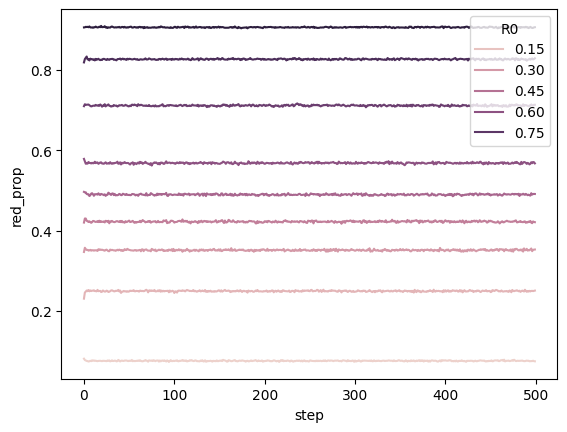

In [87]:
import seaborn as sns

sns.lineplot(x = "step", y = "red_prop", hue = "R0", data = runs_pd_agg)

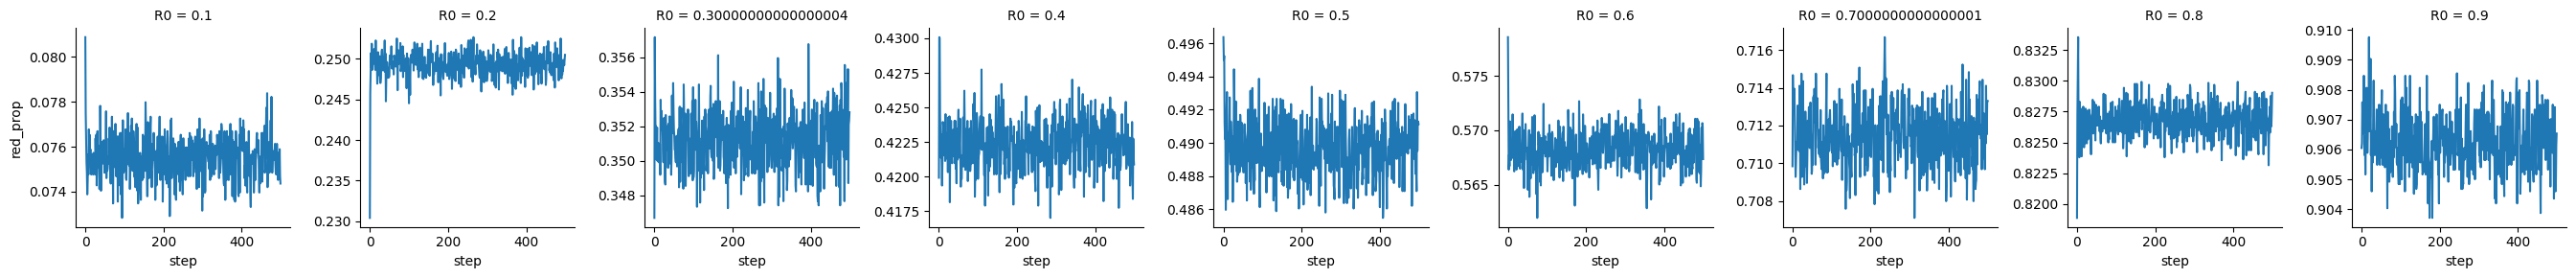

In [88]:
g = sns.FacetGrid(runs_pd_agg, col="R0", sharey=False)
g.map_dataframe(sns.lineplot, x = "step", y = "red_prop")

## Part B - Configuration Model

In [85]:
## https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html

def run_network_simulation_config(n_steps, R0, sim_number):
    Gr = nx.read_graphml('data/guava.annotated.graphml')
    Gr_degree_seq = list(dict(G.degree()).values())
    Cm = nx.configuration_model(Gr_degree_seq)
    Cm = nx.Graph(Cm)
    Cm.remove_edges_from(nx.selfloop_edges(Cm))
   # R0 = 0.60 #initial fraction of red nodes

    results = []
    #Initial condition using node attributes
    for node in list(Gr.nodes()): #loop over nodes
        die = random.uniform(0, 1)
        if die<R0:
            Gr.nodes[node]['state'] = 'red'
        else:
            Gr.nodes[node]['state'] = 'blue'

    # loop over time
    for step in range(n_steps):
        for node in list(Gr.nodes()): #loop over nodes
            neighbors = []
            for neighbor in Gr.neighbors(node): #loop over neighbors
                neighbors.append(Gr.nodes[neighbor]["state"])
            if len(neighbors) > 0:
                Gr.nodes[node]["state"] = random.sample(neighbors,1)[0]
        counts = Counter(list(nx.get_node_attributes(Gr, "state").values()))
        results.append({"sim_number": sim_number, "R0": R0, "step": step, "counts": counts})

    results_df = pd.DataFrame.from_dict(results)
    results_df_clean = results_df.drop('counts', axis=1).join(pd.DataFrame(results_df.counts.values.tolist()))
    
    return results_df_clean

,step,R0,red_prop
0,0,0.1,0.091780
1,0,0.2,0.317871
2,0,0.3,0.571812
3,0,0.4,0.807984
4,0,0.5,1.049675
...,...,...,...
4495,499,0.5,1.073711
4496,499,0.6,1.460529
4497,499,0.7,2.888147
4498,499,0.8,6.179585


[19,
 41,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 4,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 3,
 4,
 2,
 44,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 5,
 8,
 6,
 3,
 5,
 9,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 2,
 9,
 1,
 1,
 1,
 1,
 1,
 6,
 9,
 13,
 1,
 14,
 1,
 7,
 2,
 1,
 1,
 5,
 16,
 7,
 62,
 6,
 8,
 12,
 51,
 55,
 5,
 5,
 1,
 8,
 1,
 5,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 8,
 13,
 6,
 10,
 3,
 1,
 1,
 3,
 14,
 60,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 3,
 4,
 1,
 2,
 23,
 2,
 2,
 21,
 1,
 3,
 2,
 2,
 2,
 3,
 1,
 1,
 2,
 8,
 2,
 12,
 2,
 2,
 2,
 2,
 3,
 4,
 1,
 2,
 1,
 2,
 1,
 2,
 3,
 1,
 12,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 8,
 1,
 8,
 1,
 4,
 1,
 1,
 1,
 6,
 4,
 4,
 5,
 3,
 1,
 3,
 1,
 1,
 5,
 4,
 4,
 5,
 2,
 1,
 6,
 4,
 4,
 5,
 3,
 1,
 10,
 4,
 14,
 1,
 11,
 15,
 33,
 7,
 16,
 16,
 42,
 11,
 22,
 4,
 12,
 4,
 6,
 4,
 20,
 10,
 